## 3. 엽록소 형광 이미지 처리
- '2'에서 진행 내용과 유사합니다.
- 본 예제에서는 이미지 촬영 시 저장된 **.png 파일**과 **.csv 파일**을 이용하여 **식물 전체 영역**에 대한 **엽록소 형광 평균값**을 구하는 실습을 진행합니다.

> 3-1. BiRefNet을 활용한 Segmentation 이후 평균값 추출

> 3-2. 추가적인 엽록소 형광 지표 계산 (Fv/Fm, ETR, Y(II))

> 3-3. SAM2을 활용한 개별 객체 Segmentation 이후 지표 평균값 추출 예제

- 먼저 본 예제 파일과 같은 경로상에 분석을 원하는 파일을 배치.  

```
TIFF 파일 경로: '../img_src/CF/tiff_file' 
CSV, PNG 파일 경로: '../img_src/CF/cf_samples_for_additional_cal'
```

<hr>

### 3-1. BiRefNet을 활용한 Segmentation 이후 평균값 추출
- 아래의 내용에서는 BiRefNet 모델을 이용하여 배경을 제거하는 방법을 살펴봅니다.
- 테스트용 이미지로는 'rice_sample.jpg' 또는 'cf_sample.png'로 해보겠습니다.

### BiRefNet

> https://github.com/ZhengPeng7/BiRefNet
- Github 레포에서 clone을 통해서 다운받고, 모델 웨이트는 Hugging Face hub를 이용해 모델을 다운받습니다. 
- CAAI 24에서 발표된 모델로서 배경과 물체를 이진 분류합니다.
- 먼저, 분석을 원하는 이미지 파일을 'img_src -> CF' 경로에 넣습니다. 
- 아래 예시에서는 엽록소 형광 이미지인 'cf_sample.png' 파일을 이용하였습니다.

```bash
git clone https://github.com/ZhengPeng7/BiRefNet
```

#### 라이브러리 import

In [ ]:
# Imports
import os
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import torch
from torchvision import transforms
from IPython.display import display
import sys
sys.path.append('../')
from BiRefNet.image_proc import refine_foreground
from transformers import AutoModelForImageSegmentation

birefnet = AutoModelForImageSegmentation.from_pretrained('zhengpeng7/BiRefNet', trust_remote_code=True)

In [ ]:
# 이미지와 결과 경로 설정
src_dir = '../img_src/CF/input_dir'
dst_dir = '../results/CF/output_dir'
os.makedirs(dst_dir, exist_ok=True)

# 모델 및 변환 설정
device = 'cpu' #'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_float32_matmul_precision(['high', 'highest'][0])

birefnet.to(device)
birefnet.eval()
print('BiRefNet is ready to use.')


# 이미지 예측 및 결과 저장
image_paths = glob(os.path.join(src_dir, 'cf_sample.png'))
for image_path in image_paths:
    print('Processing {} ...'.format(image_path))
    
    # 원본 이미지 로드 및 크기 확인
    image = Image.open(image_path)
    orig_size = image.size  # (width, height)


    transform_image = transforms.Compose([
        transforms.Resize((1024, 1024)),
        transforms.Lambda(lambda img: img.convert('RGB') if img.mode == 'RGBA' else img),  # RGBA -> RGB
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    # 이미지를 1024x1024로 리사이즈
    input_images = transform_image(image).unsqueeze(0).to(device)

    # Prediction
    with torch.no_grad():
        preds = birefnet(input_images)[-1].sigmoid().cpu()
    pred = preds[0].squeeze()

    # Show Results
    pred_pil = transforms.ToPILImage()(pred)

    # 리사이즈된 마스크 이미지를 원본 크기로 변환
    pred_pil_resized = pred_pil.resize(orig_size)  # 원본 크기로 리사이즈
    
    pred_filename = 'binary_' + os.path.basename(image_path)
    pred_path = os.path.join(dst_dir, pred_filename)
    pred_pil_resized.save(pred_path)
    print('Image saved at:', pred_path)

    # pred_pil의 픽셀 값을 NumPy 배열로 변환 후 CSV 저장
    pred_array = np.array(pred_pil_resized)  # 원본 크기에서 추출
    df = pd.DataFrame(pred_array)
    
    csv_filename = 'binary_' + os.path.basename(image_path).replace('.jpg', '.csv').replace('.png', '.csv')
    csv_path = os.path.join(os.path.join(dst_dir, 'CSV'), csv_filename)
    df.to_csv(csv_path, index=False, header=None)
    print('CSV saved at:', csv_path)

    # Visualize the last sample:
    scale_ratio = 1024 / max(image.size)
    scaled_size = (int(image.size[0] * scale_ratio), int(image.size[1] * scale_ratio))

    image_masked = refine_foreground(image, pred_pil_resized)
    image_masked.putalpha(pred_pil_resized)

    display(image.resize(scaled_size))
    display(pred_pil_resized.resize(scaled_size))
    display(image_masked.resize(scaled_size))



In [ ]:
# 마스킹 이미지를 저장
masked_image_path = os.path.join(dst_dir, 'masked_' + os.path.splitext(os.path.basename(image_path))[0] + '.png')
image_masked.save(masked_image_path)

# CSV 파일에서 마스크된 좌표 읽기 및 저장
df = pd.read_csv(os.path.join(os.path.join(dst_dir,'CSV'),'binary_cf_sample.csv'), header=None)

# 마스크된 영역의 좌표 추출
coords = np.column_stack(np.where(df != 0))  # (y, x) 좌표
coords_df = pd.DataFrame(coords, columns=['y', 'x'])

# 좌표를 (x, y) 순서로 변환하여 저장
coords_df = coords_df[['x', 'y']]
coords_df.to_csv('../results/CF/output_dir/CSV/cf_sample_mask_coords.csv', index=False)

print("Masked image saved at:", masked_image_path)
print("Masked coordinates saved at:", '../results/CF/output_dir/CSV/cf_sample_mask_coords.csv')

In [ ]:
# 추출한 masking 영역의 좌표와 실제 형광 값이 담긴 데이터를 대응하여 x, y 좌표에 해당하는 값을 추출합니다. 
# 사용자는 파일명에 대한 수정이 필요합니다.


# 원본 데이터 파일
original_df = pd.read_csv(os.path.join(src_dir,'cf_sample.csv'), header=None)

values = []
for index, row in coords_df.iterrows():
    x, y = int(row['x']), int(row['y'])
    value = original_df.iloc[y, x]
    values.append({'x': x, 'y': y, 'value': value})

final_df = pd.DataFrame(values)

print(final_df.head())

final_df.to_csv('../results/CF/output_dir/CSV/cf_sample_mask_coords_value.csv', index=False) # 저장하고 싶은 이름으로 파일명을 변경합니다. 
print("Masked coordinates with values saved at:", '../results/CF/output_dir/CSV/cf_sample_mask_coords_value.csv')

<hr>

##### 번외 BiRefNet Box-guided segmentation

 - 단순 오브젝트, 배경분리 뿐만 아니라, 이미지 내의 ROI 박스를 지정해 해당 영역안의 물체만 분리 할 수 있음.
 - 아래 예제 참조.

In [ ]:
image_path = os.path.join(src_dir, "rice_sample.jpg")  # 사진 변경 시, 사용자가 분석을 원하는 파일 이름으로 변경이 필요합니다. 

# 이미지 로드 및 RGB로 변환
image = Image.open(image_path).convert("RGB")

import os
from glob import glob
import sys
sys.path.append('../')
from BiRefNet.image_proc import refine_foreground

src_dir = image_path
image_paths = glob(os.path.join(src_dir, '*'))
dst_dir = '../results/CF/output_dir'
os.makedirs(dst_dir, exist_ok=True)

print('Processing {} ...'.format(image_path))

# 이미지 변환
input_images = transform_image(image).unsqueeze(0).to('cpu')

# 예측 수행
with torch.no_grad():
    preds = birefnet(input_images)[-1].sigmoid().cpu()

# 예측 결과 가져오기
pred = preds[0].squeeze()

# PIL 이미지로 변환
pred_pil = transforms.ToPILImage()(pred)

# 예측된 이미지의 크기를 원본 이미지 크기에 맞춤
pred_pil = pred_pil.resize(image.size)

# 이미지 결과 시각화
scale_ratio = 1024 / max(image.size)
scaled_size = (int(image.size[0] * scale_ratio), int(image.size[1] * scale_ratio))

# 예측된 마스크를 사용하여 전경 추출
image_masked = refine_foreground(image, pred_pil)

# 알파 채널 추가 (예측된 마스크를 알파 채널로 사용)
image_masked.putalpha(pred_pil)

# 결과 시각화
display(image_masked.resize(scaled_size))
display(image.resize(scaled_size))
display(pred_pil.resize(scaled_size))


In [31]:
masked_image_path = os.path.join(dst_dir, 'masked_' + os.path.splitext(os.path.basename(image_path))[0] + '.png')
image_masked.save(masked_image_path)
print("Masked rice_sample image saved at:", masked_image_path)

Masked rice_sample image saved at: ../results/CF/output_dir/masked_rice_sample.png


#### Image 내에서 Box 위치 확인

In [ ]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def show_image_with_box(image_path, box):
    """
    이미지를 불러와서 지정된 박스 좌표를 이미지 위에 overlay하여 보여줍니다.
    
    Args:
    - image_path (str): 이미지 파일 경로
    - box (list): 박스 좌표 [left, top, right, bottom]
    """
    # 이미지 불러오기
    image = Image.open(image_path).convert("RGB")
    
    # 박스를 그리기 위한 ImageDraw 객체 생성
    draw = ImageDraw.Draw(image)
    
    # 박스 그리기 (좌표는 [left, top, right, bottom])
    draw.rectangle(box, outline="red", width=3)
    
    # 이미지 표시
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")  # 축 제거
    plt.show()

# 박스 좌표 예시: [left, top, right, bottom]
box = [0, 0, 600, 750]

# 예제 실행
show_image_with_box(image_path, box)

#### Box 영역 내의 물체만 Segmentation

In [ ]:
def pred_and_show(imagepath=image_path, box=[-1, -1, -1, -1]):
    # box: left, top, right, bottom
    image = Image.open(imagepath)
    w, h = image.size[:2]  # 이미지의 너비(w)와 높이(h) 가져오기

    # box가 [-1, -1, -1, -1]인 경우, 전체 이미지로 설정
    for idx_coord_value, coord_value in enumerate(box):
        if coord_value == -1:
            box[idx_coord_value] = [0, 0, w, h][idx_coord_value]

    # 지정된 box 영역을 크롭
    image_crop = image.crop(box)
    input_images = transform_image(image_crop).unsqueeze(0).to('cpu')

    # 예측 수행
    with torch.no_grad():
        preds = birefnet(input_images)[-1].sigmoid().cpu()
    pred = preds[0].squeeze()

    # canvas 준비
    canvas = torch.zeros_like(pred)
    box_to_canvas = [int(round(coord_value * (pred.shape[-1] / w, pred.shape[-2] / h)[idx_coord_value % 2])) for idx_coord_value, coord_value in enumerate(box)]

    # pred를 크기 조정하여 box 영역에 맞춤
    pred_resized = torch.nn.functional.interpolate(
        pred.unsqueeze(0).unsqueeze(0),
        size=(box_to_canvas[3] - box_to_canvas[1], box_to_canvas[2] - box_to_canvas[0]),
        mode='bilinear',
        align_corners=True
    ).squeeze()

    # pred_resized와 canvas의 크기 일치 여부 확인 후 삽입
    if pred_resized.shape[-2:] == (box_to_canvas[3] - box_to_canvas[1], box_to_canvas[2] - box_to_canvas[0]):
        canvas[box_to_canvas[1]:box_to_canvas[3], box_to_canvas[0]:box_to_canvas[2]] = pred_resized
    else:
        raise RuntimeError(f"Pred and canvas sizes do not match: pred {pred_resized.shape}, box {box_to_canvas}")

    # 결과 표시
    pred_pil = transforms.ToPILImage()(canvas)

    # 크기를 1024로 맞춰서 빠르게 표시
    scale_ratio = 1024 / max(image.size)
    scaled_size = (int(image.size[0] * scale_ratio), int(image.size[1] * scale_ratio))

    # 마스크 적용
    image_masked = image.resize((1024, 1024))
    image_masked.putalpha(pred_pil)

    # 결과 표시
    display(image_masked.resize(scaled_size))
    display(image.resize(scaled_size))
    display(pred_pil.resize(scaled_size))

    return pred_pil

# 예제 실행
pred_pil = pred_and_show(box=[0, 0, 600, 750])


<hr>

### BiRefNet + SAM2

- BiRefNet을 이용하여 이진분류를 했음에도 불구하고 사용자가 원하는 segmentation이 진행되지 않았을 경우, SAM2를 추가로 진행할 수 있습니다. 

- 예제에서는 'rice_sample'사진이 이 경우에 해당되기에 'masked_rice_sample.png'를 이용하여 다시 한번 segmentation을 진행하도록 하겠습니다.

In [ ]:
import numpy as np
import pandas as pd
import cv2, random, os
import torch
import csv
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor


 # 난수 시드 설정
seed = 69
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [ ]:
# SAM2 모델을 불러옵니다. 
# 'image_path' 부분만 수정하시면 됩니다.

sam2_checkpoint = "../segment-anything-2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device = 'cpu')
predictor = SAM2ImagePredictor(sam2_model)

image_path = os.path.join(dst_dir,"masked_rice_sample.png")  # 사용자가 분석을 원하는 파일 이름으로 변경이 필요합니다. 

image = Image.open(image_path).convert("RGB")
image = np.array(image)

predictor.set_image(image)

In [32]:
# maskig을 원하는 영역에 대한 설정을 하는 부분입니다. 

# input_point에 masking을 원하는 좌표 값을 대입합니다. 대괄호 속의 좌표 순서는 [x, y]입니다. 
# 여기서는 5개의 포인트를 지정하였습니다. 
input_point = np.array([[200, 380],[300,380],[650,220]])

# input_label에 input_point로 지정한 좌표의 masking 여부를 작성합니다. 
# '1'은 masking 영역으로 지정하는 것이며, '0'은 masking 영역에서 제거한다는 의미입니다.
# input_point의 대괄호의 수와 input_label에서 대괄호 속의 숫자의 갯수가 같아야 합니다. 
input_label = np.array([1, 1, 1])

# 아래의 그림은 좌표로 지정한 영역에 대해 초록별로 시각화 된 이미지 입니다. 
# 제거할 영역에 대해서는 빨간 별로 표시가 됩니다. 
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

'../results/CF/output_dir'

In [ ]:
# 아래의 결과 이미지는 masking된 영역에 대한 이미지입니다. 
# 원하는 영역이 잘 포함되었는지 확인하는 과정을 반복해서 진행합니다. 
# 잘 포함되지 않았다면 'input_point'의 좌표를 수정해야합니다.

print(predictor._features['image_embed'].shape, predictor._features['image_embed'][-1].shape)

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)

In [ ]:
# masking 한 영역에 대한 좌표 정보 dataframe에 저장합니다. 
masks_2d = np.squeeze(masks, axis=0)
df_masks = pd.DataFrame(masks_2d)

# DataFrame 확인
print(df_masks.shape)
print(df_masks.head())

# dataframe에서 '1'의 갯수를 구합니다. 
# '1'은 값이 있다는 것을 의미하며, '0'은 값이 없다는 것을 의미합니다. 
# 다시말해 '0'은 배경, '1'은 masking 영역으로 해석할 수 있습니다. 
num_ones_2 = np.sum(masks_2d == 1)

print(f"마스크에서 '1'의 개수: {num_ones_2}")

# 값이 1인 요소들(masking 요소들)의 x, y 좌표를 구합니다.
coordinates = df_masks.stack().reset_index()
coordinates.columns = ['y', 'x', 'value']
coordinates = coordinates[coordinates['value'] == 1]
coordinates = coordinates[['x', 'y']]
print(coordinates.head()) 

# masking 영역의 좌표를 csv 파일로 저장합니다. 
# 원하는 이름으로 저장하도록 합니다. 
coordinates.to_csv('../results/CF/output_dir/CSV/mask_rice_sample.csv', index=False)
print("Masked coordinates saved at:", '../results/CF/output_dir/CSV/mask_rice_sample.csv')

<hr>

### 3-2. 추가적인 엽록소 형광 지표 계산 (Fv/Fm, phiPS2, ETR)
- 본 예제에서는 'cf_samples_for_additional_cal' 폴더에 있는 데이터를 이용합니다.
- 촬영된 사진이 TIFF 파일인 경우 아래의 가공 코드를 활용해 CSV 파일와 PNG 파일로 저장한 뒤 동일하게 진행할 수 있습니다.

#### TIFF 파일의 경우 아래의 코드를 통해 CSV 파일과 PNG 파일로 변환

In [66]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image

# 경로 설정
src_dir = '../img_src/CF/tiff_file'
dst_dir = '../img_src/CF/cf_samples_for_additional_cal'
os.makedirs(dst_dir, exist_ok=True)

# TIFF 파일들을 찾음
tiff_files = glob(os.path.join(src_dir, '*.tiff'))

# 모든 TIFF 파일 처리
for tiff_file in tiff_files:
    print(f"Processing {tiff_file}...")

    # TIFF 파일 읽기 (이미지 데이터를 변경하지 않고 그대로 읽음)
    tiff_image = cv2.imread(tiff_file, cv2.IMREAD_UNCHANGED)

    if tiff_image is None:
        print(f"Error reading {tiff_file}")
        continue

    base_filename = os.path.basename(tiff_file).replace('CF_','')
    # TIFF 파일을 2차원 CSV로 저장 (파일명 유지, 확장자만 .csv로 변경)
    csv_filename = os.path.splitext(os.path.basename(base_filename))[0] + '.csv'
    csv_path = os.path.join(dst_dir, csv_filename)

    # 실수형으로 변환하여 CSV로 저장
    df = pd.DataFrame(tiff_image.astype(float))
    df.to_csv(csv_path, index=False, header=False)
    print(f"Saved CSV: {csv_path}")

    # Jet colormap을 적용하여 PNG 파일로 변환
    tiff_image_normalized = cv2.normalize(tiff_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    tiff_image_colormap = cv2.applyColorMap(tiff_image_normalized, cv2.COLORMAP_JET)

    # PNG 파일로 저장 (파일명 유지, 확장자만 .png로 변경)
    png_filename = os.path.splitext(os.path.basename(base_filename))[0] + '.png'
    png_path = os.path.join(dst_dir, png_filename)
    
    # 컬러맵이 적용된 이미지를 PNG로 저장
    Image.fromarray(cv2.cvtColor(tiff_image_colormap, cv2.COLOR_BGR2RGB)).save(png_path)
    print(f"Saved PNG: {png_path}")

Processing ../img_src/CF/tiff_file/CF_F0.tiff...
Saved CSV: ../img_src/CF/cf_samples_for_additional_cal/F0.csv
Saved PNG: ../img_src/CF/cf_samples_for_additional_cal/F0.png


In [48]:
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Union
import cv2
import os
from PIL import Image

dir_name = str('../img_src/CF/cf_samples_for_additional_cal')

try:
    if not(os.path.isdir(dir_name)):
        os.makedirs(os.path.join(dir_name))
except OSError as e:
    print(f"Error: {e} - {dir_name}")
    raise

## Parameters calculation : Fv/Fm, phiPS2, ETR
bg_array = np.loadtxt("%s/bg.csv" %dir_name, delimiter=",", dtype=np.float32)
F0_array = np.loadtxt("%s/F0.csv" %dir_name, delimiter=",", dtype=np.float32)
F0_array  = F0_array - bg_array
Fm_array = np.loadtxt("%s/Fm.csv" %dir_name, delimiter=",", dtype=np.float32)
Fm_array = Fm_array - bg_array
FtLss_array = np.loadtxt("%s/Ft_p_4.csv" %dir_name, delimiter=",", dtype=np.float32)
FtLss_array = FtLss_array - bg_array
FmLss_array = np.loadtxt("%s/Fm_p_4.csv" %dir_name, delimiter=",", dtype=np.float32)
FmLss_array = FmLss_array - bg_array

#### CSV에 저장된 마스킹 좌표와 실제 마스킹 이미지가 일치하는지 확인

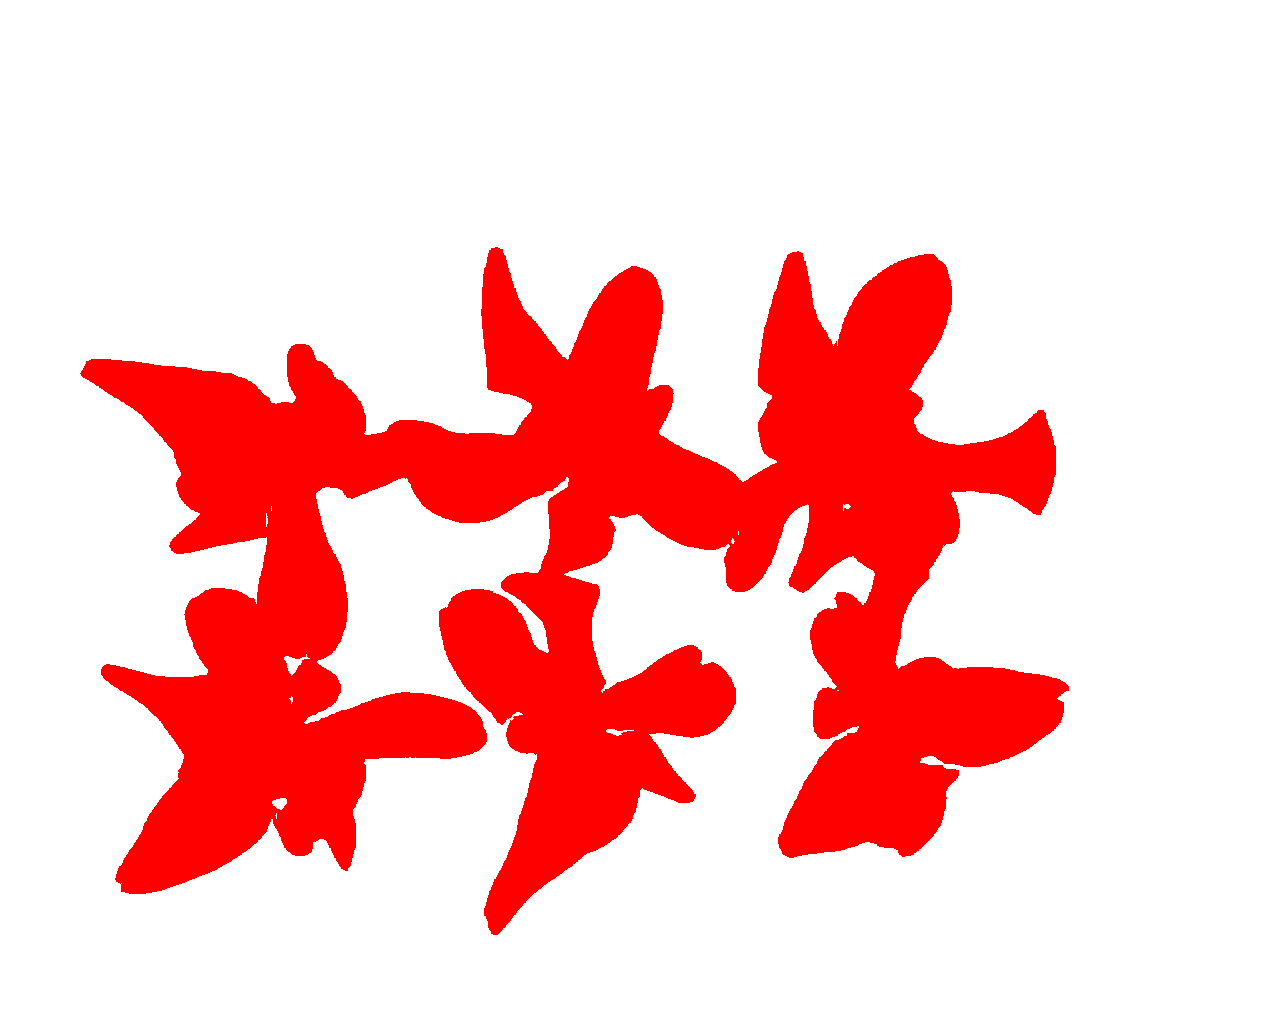

In [43]:
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw

# 원본 이미지와 좌표 파일 불러오기
image = Image.open("../results/CF/output_dir/masked_cf_sample.png")  # 원본 이미지
mask_coords_df = pd.read_csv('../results/CF/output_dir/CSV/cf_sample_mask_coords.csv')  # 마스킹 좌표 파일

# 좌표를 리스트로 변환 (x, y 순서)
mask_coords = mask_coords_df.values

# 좌표 시각화를 위해 이미지에 마스킹 좌표 표시
draw = ImageDraw.Draw(image)

# 마스킹 좌표에 점 찍기 (좌표 순서에 유의)
for coord in mask_coords:
    x, y = coord
    draw.point((x, y), fill='red')  # 빨간색 점으로 표시

# 마스킹 좌표가 찍힌 이미지 출력
display(image)

# 마스킹 좌표와 원본 이미지가 일치하는지 시각적으로 확인

### Fv/Fm 계산

In [49]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import cv2

# 마스킹 좌표 파일 불러오기
mask_coords_df = pd.read_csv('../results/CF/output_dir/CSV/cf_sample_mask_coords.csv')  # 마스킹 영역의 좌표 파일

# FvFm 계산에 필요한 데이터 불러오기
src_dir = '../img_src/CF/cf_samples_for_additional_cal'
dst_dir = '../results/CF/output_dir'
dst_csv_dir = os.path.join(dst_dir, 'CSV')

bg_array = np.loadtxt("%s/bg.csv" %dir_name, delimiter=",", dtype=np.float32)
F0_array = np.loadtxt(f"{dir_name}/F0.csv", delimiter=",", dtype=np.float32)
F0_array = F0_array - bg_array
Fm_array = np.loadtxt(f"{dir_name}/Fm.csv", delimiter=",", dtype=np.float32)
Fm_array = Fm_array - bg_array

# FvFm 계산
Fv_array = Fm_array - F0_array
Fv_array[Fv_array < 0] = 0
Fm_array = Fm_array + 1

FvFm_array = Fv_array / Fm_array
FvFm_array[FvFm_array >= 1] = 0

# 마스킹 좌표에 해당하는 FvFm 값을 추출하여 평균 계산
mask_coords = mask_coords_df.values  # 마스킹 좌표 (x, y)

# 좌표가 (x, y) 형식이므로 NumPy 배열에서는 반대로 접근해야 합니다 (y, x 순서로 접근)
masked_FvFm_values = FvFm_array[mask_coords[:, 1], mask_coords[:, 0]]  # y, x 순서로 좌표 접근

# 마스킹 영역의 FvFm 평균 값 계산
mean_FvFm = np.mean(masked_FvFm_values)
print(f"Masked FvFm Mean: {mean_FvFm}")

# 빈 마스크 배열 생성 (원본 FvFm 크기와 동일한 0으로 채워진 배열)
mask = np.zeros_like(FvFm_array)

# 마스킹 좌표에 해당하는 위치에 FvFm 값을 넣음 (y, x 순서로 값 할당)
mask[mask_coords[:, 1], mask_coords[:, 0]] = FvFm_array[mask_coords[:, 1], mask_coords[:, 0]]

# 마스킹된 FvFm 배열을 16비트로 변환하여 이미지로 저장
mask16 = (mask * 65535).astype(np.uint16)
masked_FvFm_img = cv2.applyColorMap((mask16 / 256).astype(np.uint8), cv2.COLORMAP_JET)

# 마스킹된 FvFm 이미지를 저장
masked_FvFm_img_pil = Image.fromarray(cv2.cvtColor(masked_FvFm_img, cv2.COLOR_BGR2RGB))
masked_FvFm_img_pil.save(f"{dst_dir}/Masked_FvFm_only.png")

# 결과 CSV 저장
np.savetxt(f"{dst_csv_dir}/Masked_FvFm_only.csv", mask, fmt='%6f', delimiter=',')
print("Masked FvFm calculation and image saving completed.")


Masked FvFm Mean: 0.8375527262687683
Masked FvFm calculation and image saving completed.


### phiPS2 계산

In [51]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image

# 마스킹 좌표 파일 불러오기
mask_coords_df = pd.read_csv('../results/CF/output_dir/CSV/cf_sample_mask_coords.csv')  # 마스킹 영역의 좌표 파일

# FvFm 계산에 필요한 데이터 불러오기
src_dir = '../img_src/CF/cf_samples_for_additional_cal'
dst_dir = '../results/CF/output_dir'
dst_csv_dir = os.path.join(dst_dir, 'CSV')

bg_array = np.loadtxt("%s/bg.csv" %dir_name, delimiter=",", dtype=np.float32)
FmLss_array = np.loadtxt("%s/Fm_p_4.csv" % dir_name, delimiter=",", dtype=np.float32)
FmLss_array = FmLss_array - bg_array
FtLss_array = np.loadtxt("%s/Ft_p_4.csv" % dir_name, delimiter=",", dtype=np.float32)
FtLss_array = FtLss_array - bg_array



# phiPS2 계산 (마스킹된 영역에 대해서만 처리)
phiPS2_array = (FmLss_array - FtLss_array) / FmLss_array
phiPS2_array[phiPS2_array < 0] = 0
phiPS2_array16 = phiPS2_array * 65535
raw_phiPS2_img = phiPS2_array16.astype(np.float32)

# 마스킹 좌표 (x, y)를 사용해 마스킹된 영역의 phiPS2 값을 추출
mask_coords = mask_coords_df.values  # 마스킹 좌표 (x, y)
masked_phiPS2_values = phiPS2_array[mask_coords[:, 1], mask_coords[:, 0]]  # (y, x) 순서로 좌표 접근

# 마스킹된 영역의 phiPS2 평균 계산
mean_masked_phiPS2 = np.mean(masked_phiPS2_values)
print(f"Mean Masked phiPS2: {mean_masked_phiPS2}")

# 이미지를 만들기 위해 전체 배열 크기를 유지하면서 마스킹된 좌표에만 값을 적용
masked_phiPS2_array = np.zeros_like(phiPS2_array16)
for idx, row in mask_coords_df.iterrows():
    x, y = row['x'], row['y']
    masked_phiPS2_array[y, x] = raw_phiPS2_img[y, x]

# 마스킹된 영역을 가진 이미지 저장
phiPS2_img = cv2.applyColorMap((masked_phiPS2_array / 256).astype(np.uint8), cv2.COLORMAP_JET)
phiPS2_img2 = Image.fromarray(cv2.cvtColor(phiPS2_img, cv2.COLOR_BGR2RGB))
phiPS2_img2.save("%s/Masked_phiPS2_only.png" % dst_dir)

# 전체 phiPS2 배열 저장 (전체 이미지 크기와 동일)
np.savetxt("%s/Masked_phiPS2_array.csv" % dst_csv_dir, phiPS2_array, fmt='%6f', delimiter=',')

# phiPS2 계산 완료 메시지 출력
print('phiPS2 calculation for masked region is completed')

/var/folders/p0/12zd_6x973jgb9h4wrc1fm_40000gn/T/ipykernel_17155/684906440.py:23: RuntimeWarning: divide by zero encountered in divide
  phiPS2_array = (FmLss_array - FtLss_array) / FmLss_array


Mean Masked phiPS2: 0.8003206253051758
phiPS2 calculation for masked region is completed


### ETR

In [54]:
import numpy as np
import cv2
from PIL import Image
import pandas as pd


# FvFm 계산에 필요한 데이터 불러오기
src_dir = '../img_src/CF/cf_samples_for_additional_cal'
dst_dir = '../results/CF/output_dir'
dst_csv_dir = os.path.join(dst_dir, 'CSV')

# Load phiPS2 array and mask coordinates
phiPS2_array = np.loadtxt("%s/Masked_phiPS2_array.csv" % dst_csv_dir, delimiter=",", dtype=np.float32)
mask_coords_df = pd.read_csv('../results/CF/output_dir/CSV/cf_sample_mask_coords.csv')  # 마스킹 영역의 좌표 파일


# ETR 계산
PAR = 120  # actinic light (ppfd)
ETR = PAR * 0.84 * 0.5 * phiPS2_array

# 마스킹된 좌표에 대해서만 ETR 값을 추출하여 평균 계산
mask_coords = mask_coords_df.values  # 마스킹 좌표 (x, y)
masked_ETR_values = ETR[mask_coords[:, 1], mask_coords[:, 0]]  # y, x 순서로 좌표 접근

# 마스킹된 영역의 평균 ETR 계산
mean_masked_ETR = np.mean(masked_ETR_values)
print(f"Mean Masked ETR: {mean_masked_ETR}")

# 마스킹된 좌표에 대해 ETR 값을 적용 (이미지 생성을 위해)
masked_ETR = np.zeros_like(ETR)
for idx, row in mask_coords_df.iterrows():
    x, y = row['x'], row['y']
    masked_ETR[y, x] = ETR[y, x]

# 1퍼센타일과 99퍼센타일 사이의 값만 사용하여 클리핑
low, high = np.percentile(masked_ETR[masked_ETR > 0], [1, 99])
ETR_clipped = np.clip(masked_ETR, low, high)

# ETR 값을 정규화하고 16비트로 변환
ETR_normalized = (ETR_clipped - np.min(ETR_clipped)) / (np.max(ETR_clipped) - np.min(ETR_clipped))
ETR_16bit = (ETR_normalized * 65535).astype(np.uint16)

# 컬러맵 적용 후 이미지 저장
ETR_img = cv2.applyColorMap((ETR_16bit / 256).astype(np.uint8), cv2.COLORMAP_JET)
ETR_img_rgb = Image.fromarray(cv2.cvtColor(ETR_img, cv2.COLOR_BGR2RGB))
ETR_img_rgb.save("%s/Masked_ETR_only.png" % dst_dir)

# 클리핑된 ETR 값을 CSV 파일로 저장
np.savetxt("%s/Masked_ETR.csv" % dst_csv_dir, ETR_clipped, fmt='%6f', delimiter=',')

print("ETR calculation for masked region is completed")


Mean Masked ETR: 40.33615493774414
ETR calculation for masked region is completed


### NPQ

In [55]:
import numpy as np
import cv2
from PIL import Image
import pandas as pd

src_dir = '../img_src/CF/cf_samples_for_additional_cal'
dst_dir = '../results/CF/output_dir'
dst_csv_dir = os.path.join(dst_dir, 'CSV')

# Load mask coordinates
mask_coords_df = pd.read_csv('../results/CF/output_dir/CSV/cf_sample_mask_coords.csv')  # 마스킹 영역의 좌표 파일

# Load Fm_array, FmLss_array and mask coordinates
bg_array = np.loadtxt("%s/bg.csv" %dir_name, delimiter=",", dtype=np.float32)
Fm_array = np.loadtxt("%s/Fm.csv" % src_dir, delimiter=",", dtype=np.float32)
Fm_array = Fm_array - bg_array
FmLss_array = np.loadtxt("%s/Fm_p_4.csv" % src_dir, delimiter=",", dtype=np.float32)
FmLss_array = FmLss_array - bg_array

# NPQ 계산
nsub_array = Fm_array - FmLss_array
nsub_array[nsub_array < 0] = 0
FmLss_array = FmLss_array + 1
NPQ_array = nsub_array / FmLss_array
NPQ_array[NPQ_array >= 1] = 0
NPQ_array16 = NPQ_array * 65535
raw_NPQ_img = NPQ_array16.astype(np.uint16)

# 마스킹된 좌표에 대해 NPQ 값을 추출하여 0이 아닌 값만 평균 계산
mask_coords = mask_coords_df.values  # 마스킹 좌표 (x, y)
masked_NPQ_values = NPQ_array[mask_coords[:, 1], mask_coords[:, 0]]  # y, x 순서로 좌표 접근

# 0이 아닌 값들만 선택하여 평균 계산
non_zero_masked_NPQ_values = masked_NPQ_values[masked_NPQ_values != 0]

# 마스킹된 영역의 평균 NPQ 계산 (0이 아닌 값만 사용)
if len(non_zero_masked_NPQ_values) > 0:
    mean_masked_NPQ = np.mean(non_zero_masked_NPQ_values)
    print(f"Mean Masked NPQ (excluding 0 values): {mean_masked_NPQ}")
else:
    print("No non-zero NPQ values found in the masked region.")

# 마스킹된 좌표에 대해 NPQ 값을 적용 (이미지 생성을 위해)
masked_NPQ_array = np.zeros_like(NPQ_array16)
for idx, row in mask_coords_df.iterrows():
    x, y = row['x'], row['y']
    masked_NPQ_array[y, x] = raw_NPQ_img[y, x]

# 컬러맵 적용 후 이미지 저장
NPQ_img = cv2.applyColorMap((masked_NPQ_array / 256).astype(np.uint8), cv2.COLORMAP_JET)
NPQ_img_rgb = Image.fromarray(cv2.cvtColor(NPQ_img, cv2.COLOR_BGR2RGB))
NPQ_img_rgb.save("%s/Masked_NPQ_only.png" % dst_dir)

# 마스킹된 NPQ 값을 CSV 파일로 저장
np.savetxt("%s/Masked_NPQ.csv" % dst_csv_dir, NPQ_array, fmt='%6f', delimiter=',')

print("NPQ calculation for masked region is completed")

Mean Masked NPQ (excluding 0 values): 0.7083451151847839
NPQ calculation for masked region is completed


### qP

In [64]:
import numpy as np
import cv2
from PIL import Image
import pandas as pd


src_dir = '../img_src/CF/cf_samples_for_additional_cal'
dst_dir = '../results/CF/output_dir'
dst_csv_dir = os.path.join(dst_dir, 'CSV')

# Load mask coordinates
mask_coords_df = pd.read_csv('../results/CF/output_dir/CSV/cf_sample_mask_coords.csv')  # 마스킹 영역의 좌표 파일


# Load F0_array, Fm_array, FmLss_array, F0Lss_array 
bg_array = np.loadtxt("%s/bg.csv" %dir_name, delimiter=",", dtype=np.float32)
F0_array = np.loadtxt("%s/F0.csv" % src_dir, delimiter=",", dtype=np.float32)
F0_array = F0_array - bg_array
Fm_array = np.loadtxt("%s/Fm.csv" % src_dir, delimiter=",", dtype=np.float32)
Fm_array = Fm_array - bg_array
FmLss_array = np.loadtxt("%s/Fm_p_4.csv" % src_dir, delimiter=",", dtype=np.float32)
FmLss_array = FmLss_array - bg_array


# qP 계산
F0_array = F0_array + 1
F0Lss_array = 1 / (1 / F0_array - 1 / Fm_array + 1 / FmLss_array + 0.0001)
FvLss_array = FmLss_array - F0Lss_array + 1
ysub_array = FmLss_array - F0Lss_array  # ysub_array를 FvLss_array 계산 후 추가
qP_array = ysub_array / (FvLss_array + 0.0001)
qP_array[qP_array >= 1] = 0
qP_array16 = qP_array * 65535
raw_qP_img = qP_array16.astype(np.uint16)

# 마스킹된 좌표에 대해 qP 값을 추출하여 평균 계산
mask_coords = mask_coords_df.values  # 마스킹 좌표 (x, y)
masked_qP_values = qP_array[mask_coords[:, 1], mask_coords[:, 0]]  # y, x 순서로 좌표 접근

# 마스킹된 영역의 평균 qP 계산
mean_masked_qP = np.mean(masked_qP_values)
print(f"Mean Masked qP: {mean_masked_qP}")

# 마스킹된 좌표에 대해 qP 값을 적용 (이미지 생성을 위해)
masked_qP_array = np.zeros_like(qP_array16)
for idx, row in mask_coords_df.iterrows():
    x, y = row['x'], row['y']
    masked_qP_array[y, x] = raw_qP_img[y, x]

# 컬러맵 적용 후 이미지 저장
qP_img = cv2.applyColorMap((masked_qP_array / 256).astype(np.uint8), cv2.COLORMAP_JET)
qP_img_rgb = Image.fromarray(cv2.cvtColor(qP_img, cv2.COLOR_BGR2RGB))
qP_img_rgb.save("%s/Masked_qP_only.png" % dst_dir)

# 마스킹된 qP 값을 CSV 파일로 저장
np.savetxt("%s/Masked_qP.csv" % dst_csv_dir, qP_array, fmt='%6f', delimiter=',')

print("qP calculation for masked region is completed")


/var/folders/p0/12zd_6x973jgb9h4wrc1fm_40000gn/T/ipykernel_17155/4141321423.py:27: RuntimeWarning: divide by zero encountered in divide
  F0Lss_array = 1 / (1 / F0_array - 1 / Fm_array + 1 / FmLss_array + 0.0001)


Mean Masked qP: 0.9713854789733887
qP calculation for masked region is completed


### qN

In [65]:
import numpy as np
import cv2
from PIL import Image
import pandas as pd

src_dir = '../img_src/CF/cf_samples_for_additional_cal'
dst_dir = '../results/CF/output_dir'
dst_csv_dir = os.path.join(dst_dir, 'CSV')

# Load mask coordinates
mask_coords_df = pd.read_csv('../results/CF/output_dir/CSV/cf_sample_mask_coords.csv')  # 마스킹 영역의 좌표 파일


# Load F0_array, Fm_array, FmLss_array, 
bg_array = np.loadtxt("%s/bg.csv" %src_dir, delimiter=",", dtype=np.float32)
F0_array = np.loadtxt("%s/F0.csv" % src_dir, delimiter=",", dtype=np.float32)
F0_array = F0_array - bg_array
Fm_array = np.loadtxt("%s/Fm.csv" % src_dir, delimiter=",", dtype=np.float32)
Fm_array = Fm_array - bg_array
FmLss_array = np.loadtxt("%s/Fm_p_4.csv" % src_dir, delimiter=",", dtype=np.float32)
FmLss_array = FmLss_array - bg_array


# qN 계산
qN_array = 1 - (FmLss_array - F0_array) / (Fm_array - F0_array)
qN_array[qN_array < 0] = 0
qN_array[qN_array > 1] = 1
qN_array16 = qN_array * 65535
raw_qN_img = qN_array16.astype(np.uint16)

# 마스킹된 좌표에 대해 qN 값을 추출하여 평균 계산
mask_coords = mask_coords_df.values  # 마스킹 좌표 (x, y)
masked_qN_values = qN_array[mask_coords[:, 1], mask_coords[:, 0]]  # y, x 순서로 좌표 접근

# 마스킹된 영역의 평균 qN 계산
mean_masked_qN = np.mean(masked_qN_values)
print(f"Mean Masked qN: {mean_masked_qN}")

# 마스킹된 좌표에 대해 qN 값을 적용 (이미지 생성을 위해)
masked_qN_array = np.zeros_like(qN_array16)
for idx, row in mask_coords_df.iterrows():
    x, y = row['x'], row['y']
    masked_qN_array[y, x] = raw_qN_img[y, x]

# 컬러맵 적용 후 이미지 저장
qN_img = cv2.applyColorMap((masked_qN_array / 256).astype(np.uint8), cv2.COLORMAP_JET)
qN_img_rgb = Image.fromarray(cv2.cvtColor(qN_img, cv2.COLOR_BGR2RGB))
qN_img_rgb.save("%s/Masked_qN_only.png" % dst_dir)

# 마스킹된 qN 값을 CSV 파일로 저장
np.savetxt("%s/Masked_qN.csv" % dst_csv_dir, qN_array, fmt='%6f', delimiter=',')

print("qN calculation for masked region is completed")

Mean Masked qN: 0.7750779390335083
qN calculation for masked region is completed


<hr>

### 3-3 SAM2을 활용한 개별 객체 Segmentation 이후 지표 평균값 추출 예제

#### Segmentation
- 이전 예제에서 사용하였던 SAM2를 활용하여 식물 영역을 추출하고 평균값을 계산합니다. 

In [ ]:
import numpy as np
import pandas as pd
import cv2, random, os
import torch
import csv
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor


 # 난수 시드 설정
seed = 69
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [ ]:
# SAM2 모델을 불러옵니다. 
# 'image_path' 부분만 수정하시면 됩니다.

sam2_checkpoint = "../segment-anything-2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device = 'cpu')
predictor = SAM2ImagePredictor(sam2_model)

image_path = "../results/CF/output_dir/Masked_ETR_only.png"  # 사용자가 분석을 원하는 파일 이름으로 변경이 필요합니다. 

image = Image.open(image_path).convert("RGB")
image = np.array(image)

predictor.set_image(image)

In [ ]:
# maskig을 원하는 영역에 대한 설정을 하는 부분입니다. 

# input_point에 masking을 원하는 좌표 값을 대입합니다. 대괄호 속의 좌표 순서는 [x, y]입니다. 
# 여기서는 5개의 포인트를 지정하였습니다. 
input_point = np.array([[200, 410]])

# input_label에 input_point로 지정한 좌표의 masking 여부를 작성합니다. 
# '1'은 masking 영역으로 지정하는 것이며, '0'은 masking 영역에서 제거한다는 의미입니다.
# input_point의 대괄호의 수와 input_label에서 대괄호 속의 숫자의 갯수가 같아야 합니다. 
input_label = np.array([1])

# 아래의 그림은 좌표로 지정한 영역에 대해 초록별로 시각화 된 이미지 입니다. 
# 제거할 영역에 대해서는 빨간 별로 표시가 됩니다. 
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [ ]:
# 아래의 결과 이미지는 masking된 영역에 대한 이미지입니다. 
# 원하는 영역이 잘 포함되었는지 확인하는 과정을 반복해서 진행합니다. 
# 잘 포함되지 않았다면 'input_point'의 좌표를 수정해야합니다.

print(predictor._features['image_embed'].shape, predictor._features['image_embed'][-1].shape)

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)

In [ ]:
# masking 한 영역에 대한 좌표 정보 dataframe에 저장합니다. 
masks_2d = np.squeeze(masks, axis=0)
df_masks = pd.DataFrame(masks_2d)

# DataFrame 확인
print(df_masks.shape)
print(df_masks.head())

# dataframe에서 '1'의 갯수를 구합니다. 
# '1'은 값이 있다는 것을 의미하며, '0'은 값이 없다는 것을 의미합니다. 
# 다시말해 '0'은 배경, '1'은 masking 영역으로 해석할 수 있습니다. 
num_ones_2 = np.sum(masks_2d == 1)

print(f"마스크에서 '1'의 개수: {num_ones_2}")

# 값이 1인 요소들(masking 요소들)의 x, y 좌표를 구합니다.
coordinates = df_masks.stack().reset_index()
coordinates.columns = ['y', 'x', 'value']
coordinates = coordinates[coordinates['value'] == 1]
coordinates = coordinates[['x', 'y']]
print(coordinates.head()) 

# masking 영역의 좌표를 csv 파일로 저장합니다. 
# 원하는 이름으로 저장하도록 합니다. 
coordinates.to_csv('../results/CF/output_dir/CSV/SAM2_mask_etr_sample.csv', index=False)

In [ ]:
# 추출한 masking 영역의 좌표와 실제 형광 값이 담긴 데이터를 대응하여 x, y 좌표에 해당하는 값을 추출합니다. 
# 사용자는 파일명에 대한 수정이 필요합니다.

coordinates_df = coordinates.copy()
# 원본 데이터 파일
original_df = pd.read_csv('../img_src/CF/cf_samples_for_additional_cal/ETR.csv', header=None)

values = []
for index, row in coordinates_df.iterrows():
    x, y = int(row['x']), int(row['y'])
    value = original_df.iloc[y, x]
    values.append({'x': x, 'y': y, 'value': value})

final_df = pd.DataFrame(values)

print(final_df.head())

final_df.to_csv('../results/CF/output_dir/CSV/mask_etr_fin.csv', index=False) # 저장하고 싶은 이름으로 파일명을 변경합니다. 
print("'mask_etr_fin.csv'에 저장되었습니다.") # 위와 같은 파일명으로 수정합니다.

In [ ]:
# masking 영역의 평균 ETR 값은 아래와 같습니다. 
final_df['value'].mean()